### --- Data Cleaning ---

In [1]:
import os
import warnings
import pickle
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, confusion_matrix, roc_curve
import joblib
import pprint
from tensorflow.keras.models import load_model

warnings.filterwarnings("ignore")

# Define directories
data_dir = '../data/'  # Path to the data folder
figs_dir = '../figs/'  # Path to save figures
results_dir = '../results/'  # Path to save results

# Confirmation of setup
print(f"Data directory: {os.path.abspath(data_dir)}")
print(f"Figures will be saved in: {os.path.abspath(figs_dir)}")
print(f"Results will be saved in: {os.path.abspath(results_dir)}")

# load Data
diabetic_data = "../data/diabetic_data.csv"  
IDS_mapping = '../data/IDS_mapping.csv'
df = pd.read_csv(diabetic_data)

# --- Initial Cleaning ---
drop_cols = ['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty']
df = df.drop(columns=drop_cols)

# replace '?' with 'Unknown'
df = df.replace('?', 'Unknown')

# remove patients discharged to hospice or who died
death_hospice_ids = [11, 19, 20, 21]
df = df[~df['discharge_disposition_id'].isin(death_hospice_ids)]

# keep only valid readmission labels and create binary target
df = df[df['readmitted'].isin(['NO', '<30', '>30'])].copy()
df['readmit_binary'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

# drop gender "Unknown/Invalid"
df = df[df['gender'] != 'Unknown/Invalid']

# Display basic info
df.info()

Data directory: /Users/yuanyuangao/Library/Mobile Documents/com~apple~CloudDocs/Yuanyuan Gao/UC Berkeley/UC Berkeley Academic Courses Folder/UCB Spring 2025/PBHLTH240C/ph240c/data
Figures will be saved in: /Users/yuanyuangao/Library/Mobile Documents/com~apple~CloudDocs/Yuanyuan Gao/UC Berkeley/UC Berkeley Academic Courses Folder/UCB Spring 2025/PBHLTH240C/ph240c/figs
Results will be saved in: /Users/yuanyuangao/Library/Mobile Documents/com~apple~CloudDocs/Yuanyuan Gao/UC Berkeley/UC Berkeley Academic Courses Folder/UCB Spring 2025/PBHLTH240C/ph240c/results
<class 'pandas.core.frame.DataFrame'>
Index: 100111 entries, 0 to 101765
Data columns (total 46 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      100111 non-null  object
 1   gender                    100111 non-null  object
 2   age                       100111 non-null  object
 3   admission_type_id         100111 non-null  int64 
 

### --- Visualization ---

Plot saved to ../figs/patient_distribution_summary.pdf


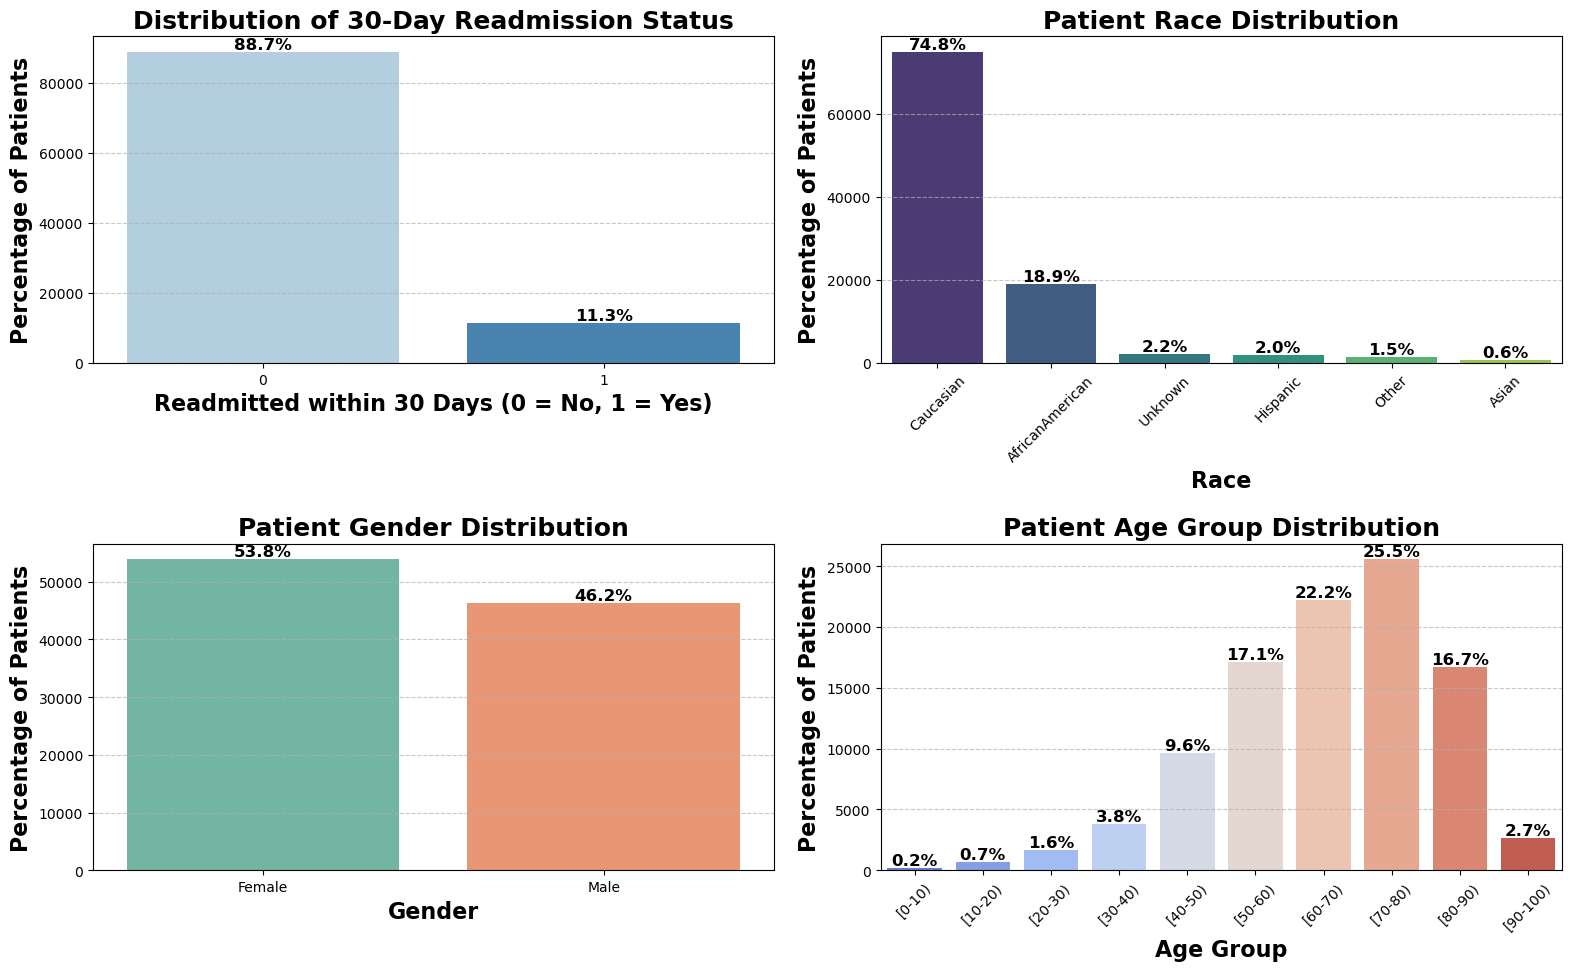

In [2]:
# --- Visualization ---
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Global font settings
plt.rcParams.update({'font.size': 16})

# --- Helper function to add percentages above bars ---
def add_percentages(ax):
    total = sum(p.get_height() for p in ax.patches)
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            percentage = 100 * height / total
            ax.annotate(f'{percentage:.1f}%', 
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom',
                        fontsize=12, fontweight='bold')

# --- Plot 1: Readmission Status ---
sns.countplot(x='readmit_binary', data=df, palette='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of 30-Day Readmission Status', fontsize=18, fontweight='bold')
axes[0, 0].set_xlabel('Readmitted within 30 Days (0 = No, 1 = Yes)', fontsize=16, fontweight='bold')
axes[0, 0].set_ylabel('Percentage of Patients', fontsize=16, fontweight='bold')
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
add_percentages(axes[0, 0])
plt.savefig("../figs/readmission_distribution.pdf", format='pdf')


# --- Plot 2: Race ---
sns.countplot(x='race', data=df, order=df['race'].value_counts().index, palette='viridis', ax=axes[0, 1])
axes[0, 1].set_title('Patient Race Distribution', fontsize=18, fontweight='bold')
axes[0, 1].set_xlabel('Race', fontsize=16, fontweight='bold')
axes[0, 1].set_ylabel('Percentage of Patients', fontsize=16, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)
add_percentages(axes[0, 1])

# --- Plot 3: Gender ---
sns.countplot(x='gender', data=df, palette='Set2', ax=axes[1, 0])
axes[1, 0].set_title('Patient Gender Distribution', fontsize=18, fontweight='bold')
axes[1, 0].set_xlabel('Gender', fontsize=16, fontweight='bold')
axes[1, 0].set_ylabel('Percentage of Patients', fontsize=16, fontweight='bold')
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)
add_percentages(axes[1, 0])

# --- Plot 4: Age Group ---
sns.countplot(x='age', data=df, order=sorted(df['age'].unique()), palette='coolwarm', ax=axes[1, 1])
axes[1, 1].set_title('Patient Age Group Distribution', fontsize=18, fontweight='bold')
axes[1, 1].set_xlabel('Age Group', fontsize=16, fontweight='bold')
axes[1, 1].set_ylabel('Percentage of Patients', fontsize=16, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)
add_percentages(axes[1, 1])

plt.tight_layout()

# --- Save to ../figs/ ---
figs_dir = "../figs/"
os.makedirs(figs_dir, exist_ok=True)  # Create folder if it doesn't exist
save_path = os.path.join(figs_dir, "patient_distribution_summary.pdf")
plt.savefig(save_path, format='pdf', dpi=300)

print(f"Plot saved to {save_path}")

plt.show()


In [3]:
# --- Save each individual plot as its own figure ---

# 1. Readmission Status
fig1, ax1 = plt.subplots(figsize=(8, 6))
sns.countplot(x='readmit_binary', data=df, palette='Blues', ax=ax1)
ax1.set_title('Distribution of 30-Day Readmission Status', fontsize=18, fontweight='bold')
ax1.set_xlabel('Readmitted within 30 Days (0 = No, 1 = Yes)', fontsize=16, fontweight='bold')
ax1.set_ylabel('Percentage of Patients', fontsize=16, fontweight='bold')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
add_percentages(ax1)
fig1.tight_layout()
fig1.savefig(os.path.join(figs_dir, "readmission_distribution.pdf"), format='pdf', dpi=300)
plt.close(fig1)

# 2. Race
fig2, ax2 = plt.subplots(figsize=(8, 6))
sns.countplot(x='race', data=df, order=df['race'].value_counts().index, palette='viridis', ax=ax2)
ax2.set_title('Patient Race Distribution', fontsize=18, fontweight='bold')
ax2.set_xlabel('Race', fontsize=16, fontweight='bold')
ax2.set_ylabel('Percentage of Patients', fontsize=16, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
add_percentages(ax2)
fig2.tight_layout()
fig2.savefig(os.path.join(figs_dir, "race_distribution.pdf"), format='pdf', dpi=300)
plt.close(fig2)

# 3. Gender
fig3, ax3 = plt.subplots(figsize=(8, 6))
sns.countplot(x='gender', data=df, palette='Set2', ax=ax3)
ax3.set_title('Patient Gender Distribution', fontsize=18, fontweight='bold')
ax3.set_xlabel('Gender', fontsize=16, fontweight='bold')
ax3.set_ylabel('Percentage of Patients', fontsize=16, fontweight='bold')
ax3.grid(axis='y', linestyle='--', alpha=0.7)
add_percentages(ax3)
fig3.tight_layout()
fig3.savefig(os.path.join(figs_dir, "gender_distribution.pdf"), format='pdf', dpi=300)
plt.close(fig3)

# 4. Age
fig4, ax4 = plt.subplots(figsize=(8, 6))
sns.countplot(x='age', data=df, order=sorted(df['age'].unique()), palette='coolwarm', ax=ax4)
ax4.set_title('Patient Age Group Distribution', fontsize=18, fontweight='bold')
ax4.set_xlabel('Age Group', fontsize=16, fontweight='bold')
ax4.set_ylabel('Percentage of Patients', fontsize=16, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(axis='y', linestyle='--', alpha=0.7)
add_percentages(ax4)
fig4.tight_layout()
fig4.savefig(os.path.join(figs_dir, "age_distribution.pdf"), format='pdf', dpi=300)
plt.close(fig4)

print("All individual plots saved successfully.")


All individual plots saved successfully.


### --- Preprocessing ---

In [4]:
# --- feature set ---
categorical_features = [
    'race', 'gender', 'age', 'admission_type_id',
    'discharge_disposition_id', 'admission_source_id',
    'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed'
] + [col for col in df.columns if col.startswith((
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'tolazamide', 'examide',
    'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'
))]

numerical_features = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
    'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses'
]

# preprocessing pipelines
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_features),
    ('num', numerical_transformer, numerical_features)
])

# split data
X = df[categorical_features + numerical_features]
y = df['readmit_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### --- Save the cleaned data ---


In [5]:
# save the cleaned data
df.to_csv('../data/data_cleaned.csv', index=False)
print("Cleaned data saved to 'data_cleaned.csv'.")

df = pd.read_csv("../data/data_cleaned.csv")
# df = pd.read_csv("../data/data_cleaned.csv")

# Display basic info
df.info()

Cleaned data saved to 'data_cleaned.csv'.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100111 entries, 0 to 100110
Data columns (total 46 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      100111 non-null  object
 1   gender                    100111 non-null  object
 2   age                       100111 non-null  object
 3   admission_type_id         100111 non-null  int64 
 4   discharge_disposition_id  100111 non-null  int64 
 5   admission_source_id       100111 non-null  int64 
 6   time_in_hospital          100111 non-null  int64 
 7   num_lab_procedures        100111 non-null  int64 
 8   num_procedures            100111 non-null  int64 
 9   num_medications           100111 non-null  int64 
 10  number_outpatient         100111 non-null  int64 
 11  number_emergency          100111 non-null  int64 
 12  number_inpatient          100111 non-null  int64 
 13  diag_1           

### --- Models ---

1. **Logistic Regression**
2. **XGBoost**
3. **Neural Network**

In [ ]:
# Handle class imbalance with scale_pos_weight
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# --- Train Logistic Regression ---
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

param_grid_logreg = {'classifier__C': [0.01, 0.1, 1, 10]}

grid_logreg = GridSearchCV(logreg_pipeline, 
                           param_grid_logreg, 
                           scoring='roc_auc', 
                           cv=5, 
                           n_jobs=-1)
grid_logreg.fit(X_train, y_train)
best_logreg = grid_logreg.best_estimator_

# --- Train XGBoost ---
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, 
                                 scale_pos_weight=scale_pos_weight,
                                 eval_metric='logloss', random_state=42))
])

param_grid_xgb = {
    'classifier__learning_rate': [0.01, 0.1, 1, 10],
    'classifier__max_depth': [3, 5, 7],
    'classifier__n_estimators': [100, 200]
}

grid_xgb = GridSearchCV(xgb_pipeline, 
                        param_grid_xgb, 
                        scoring='roc_auc', 
                        cv=5, 
                        n_jobs=-1)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_

# --- Step 1: Preprocess Inputs ---
X_train_nn = preprocessor.fit_transform(X_train)
X_test_nn = preprocessor.transform(X_test)

# --- Step 2: Apply SMOTE ---
print("\n Applying SMOTE to balance classes...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_nn, y_train)

print(f"After SMOTE balancing: {np.sum(y_train_balanced==1)} positive samples, {np.sum(y_train_balanced==0)} negative samples.")

# --- Step 3: Define and Train Neural Network with GridSearch ---
def train_nn_with_smote(X_train_balanced, y_train_balanced):
    param_grid = {
        'hidden_layer_sizes': [(50,), (50, 30), (100,)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001],
        'learning_rate_init': [0.001, 0.01]
    }

    base_mlp = MLPClassifier(
        max_iter=500,
        random_state=42,
        early_stopping=True
    )

    grid_search = GridSearchCV(
        estimator=base_mlp,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=5,
        n_jobs=-1
    )
    grid_search.fit(X_train_balanced, y_train_balanced)
    return grid_search.best_estimator_, grid_search.best_params_

# --- Step 4: Train Model ---
best_nn, best_nn_params = train_nn_with_smote(X_train_balanced, y_train_balanced)

print("\n Best Neural Network Parameters after SMOTE balancing:")
print(best_nn_params)


/Users/yuanyuangao/miniconda3/envs/215a/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:51:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuanyuangao/miniconda3/envs/215a/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:51:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuanyuangao/miniconda3/envs/215a/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:51:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuanyuangao/miniconda3/envs/215a/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:51:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_e


 Applying SMOTE to balance classes...
After SMOTE balancing: 71002 positive samples, 71002 negative samples.

 Best Neural Network Parameters after SMOTE balancing:
{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}


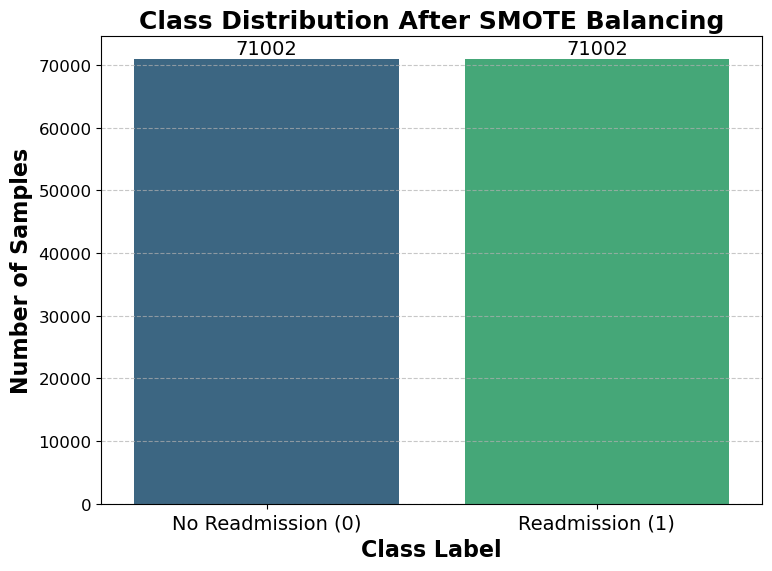

In [7]:
# Count labels after SMOTE
labels, counts = np.unique(y_train_balanced, return_counts=True)

# Barplot
plt.figure(figsize=(8, 6))
sns.barplot(x=labels, y=counts, palette='viridis')

# Labels and title
plt.xlabel('Class Label', fontsize=16, fontweight='bold')
plt.ylabel('Number of Samples', fontsize=16, fontweight='bold')
plt.title('Class Distribution After SMOTE Balancing', fontsize=18, fontweight='bold')

# Add number labels on top
for i in range(len(labels)):
    plt.text(i, counts[i]+50, counts[i], ha='center', va='bottom', fontsize=14)

plt.xticks([0,1], ['No Readmission (0)', 'Readmission (1)'], fontsize=14)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Optional: save
plt.savefig("../figs/class_distribution_after_smote.pdf", format="pdf", dpi=300)

plt.show()


In [8]:
# --- Print Best Model Parameters ---

print("\n==== Best Model Parameters ====\n")

print("Logistic Regression Best Parameters:")
print(grid_logreg.best_params_)

print("\n XGBoost Best Parameters:")
print(grid_xgb.best_params_)

print("\n Neural Network (MLP) Best Parameters:")
print(best_nn_params)

print("\n================================")


==== Best Model Parameters ====

Logistic Regression Best Parameters:
{'classifier__C': 0.1}

 XGBoost Best Parameters:
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}

 Neural Network (MLP) Best Parameters:
{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}



Models and training configs saved.


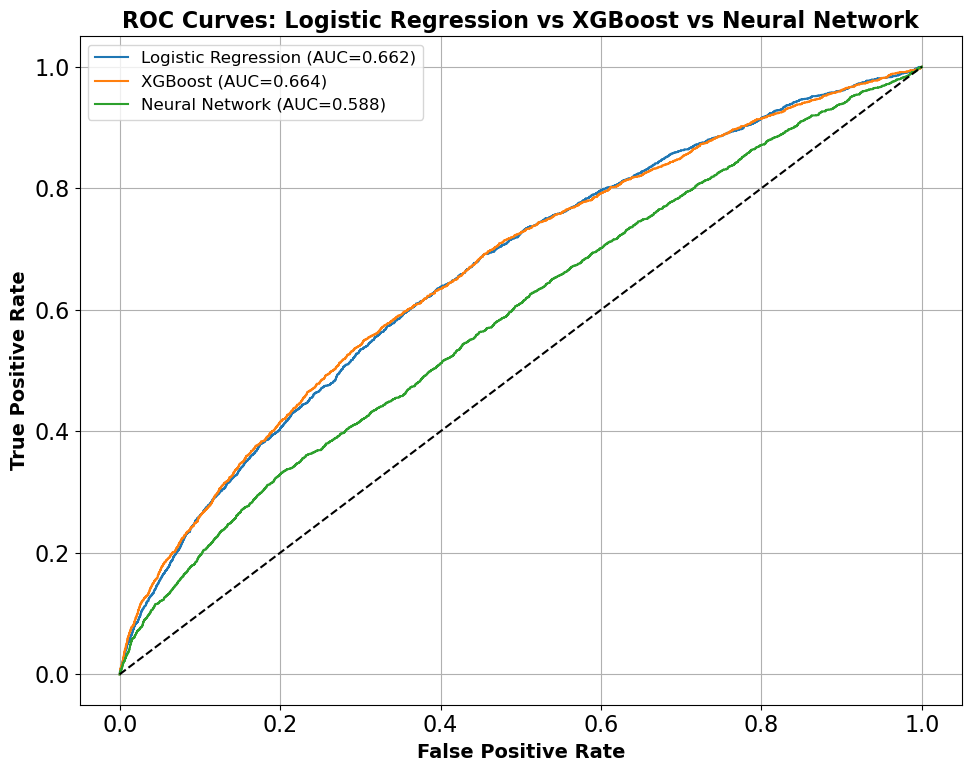

In [9]:
# --- Helper Functions ---
def compute_bootstrap_auc(y_true, y_pred, n_bootstraps=1000, seed=42):
    np.random.seed(seed)
    bootstrapped_scores = []
    for _ in range(n_bootstraps):
        indices = np.random.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    lower = sorted_scores[int(0.025 * len(sorted_scores))]
    upper = sorted_scores[int(0.975 * len(sorted_scores))]
    return lower, upper

def compute_sensitivity_specificity(y_true, y_pred_binary):
    cm = confusion_matrix(y_true, y_pred_binary)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    return sensitivity, specificity


# --- Evaluate models ---
# Predict
y_pred_logreg = best_logreg.predict_proba(X_test)[:, 1]
y_pred_xgb = best_xgb.predict_proba(X_test)[:, 1]
y_pred_nn_prob = best_nn.predict_proba(X_test_nn)[:, 1]

# Binarize
y_pred_logreg_binary = (y_pred_logreg >= 0.5).astype(int)
y_pred_xgb_binary = (y_pred_xgb >= 0.5).astype(int)
y_pred_nn_binary = (y_pred_nn_prob >= 0.5).astype(int)

# AUCs
auc_logreg = roc_auc_score(y_test, y_pred_logreg)
auc_xgb = roc_auc_score(y_test, y_pred_xgb)
auc_nn = roc_auc_score(y_test, y_pred_nn_prob)

# Confidence Intervals
auc_logreg_ci = compute_bootstrap_auc(y_test.values, y_pred_logreg)
auc_xgb_ci = compute_bootstrap_auc(y_test.values, y_pred_xgb)
auc_nn_ci = compute_bootstrap_auc(y_test.values, y_pred_nn_prob)

# Sensitivity and Specificity
sens_logreg, spec_logreg = compute_sensitivity_specificity(y_test, y_pred_logreg_binary)
sens_xgb, spec_xgb = compute_sensitivity_specificity(y_test, y_pred_xgb_binary)
sens_nn, spec_nn = compute_sensitivity_specificity(y_test, y_pred_nn_binary)

# --- Step 7: Save models ---
os.makedirs('../models/', exist_ok=True)

with open('../models/best_logistic_regression.pkl', 'wb') as f:
    pickle.dump(best_logreg, f)

with open('../models/best_xgboost.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)

with open('../models/best_neural_network.pkl', 'wb') as f:
    pickle.dump(best_nn, f)

# --- Save configs ---
full_config = {
    'logistic_regression': {
        'model': 'LogisticRegression',
        'best_params': grid_logreg.best_params_,
        'auc': auc_logreg,
        'auc_ci': auc_logreg_ci,
        'sensitivity': sens_logreg,
        'specificity': spec_logreg
    },
    'xgboost': {
        'model': 'XGBoost',
        'best_params': grid_xgb.best_params_,
        'auc': auc_xgb,
        'auc_ci': auc_xgb_ci,
        'sensitivity': sens_xgb,
        'specificity': spec_xgb
    },
    'neural_network': {
        'model': 'MLPClassifier',
        'best_params': best_nn_params,
        'auc': auc_nn,
        'auc_ci': auc_nn_ci,
        'sensitivity': sens_nn,
        'specificity': spec_nn
    }
}

with open('../models/training_configs.yaml', 'w') as f:
    yaml.dump(full_config, f)

print("Models and training configs saved.")

# --- Step 8: Plot ROC Curves ---
plt.figure(figsize=(10,8))

fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_logreg)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn_prob)

plt.plot(fpr_logreg, tpr_logreg, label=f"Logistic Regression (AUC={auc_logreg:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC={auc_xgb:.3f})")
plt.plot(fpr_nn, tpr_nn, label=f"Neural Network (AUC={auc_nn:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('ROC Curves: Logistic Regression vs XGBoost vs Neural Network', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
os.makedirs('../figs/', exist_ok=True)
plt.savefig('../figs/roc_curve_all_models.pdf', format='pdf', dpi=300)
plt.show()


In [10]:
pprint.pprint(full_config)


{'logistic_regression': {'auc': 0.6621365180304043,
                         'auc_ci': (0.6500871839041287, 0.6738955119716528),
                         'best_params': {'classifier__C': 0.1},
                         'model': 'LogisticRegression',
                         'sensitivity': 0.535006605019815,
                         'specificity': 0.698400180261379},
 'neural_network': {'auc': 0.5880541315951724,
                    'auc_ci': (0.5752643034427918, 0.6005251102914165),
                    'best_params': {'activation': 'tanh',
                                    'alpha': 0.0001,
                                    'hidden_layer_sizes': (100,),
                                    'learning_rate_init': 0.001},
                    'model': 'MLPClassifier',
                    'sensitivity': 0.2404227212681638,
                    'specificity': 0.8685218566922037},
 'xgboost': {'auc': 0.6639533573681838,
             'auc_ci': (0.6525207716151968, 0.6756401120390437),
        

In [11]:
# --- Print Results ---
print("\n==== Model AUC and 95% CI ====\n")

print(f" Logistic Regression AUC: {auc_logreg:.4f}")
print(f"95% CI: ({auc_logreg_ci[0]:.4f}, {auc_logreg_ci[1]:.4f})\n")

print(f" XGBoost AUC: {auc_xgb:.4f}")
print(f"95% CI: ({auc_xgb_ci[0]:.4f}, {auc_xgb_ci[1]:.4f})\n")

print(f" Neural Network AUC: {auc_nn:.4f}")
print(f"95% CI: ({auc_nn_ci[0]:.4f}, {auc_nn_ci[1]:.4f})\n")

print("================================\n")

# --- Save CI results to YAML ---
ci_results = {
    "logistic_regression": {
        "auc": float(auc_logreg),
        "95%_CI_lower": float(auc_logreg_ci[0]),
        "95%_CI_upper": float(auc_logreg_ci[1]),
    },
    "xgboost": {
        "auc": float(auc_xgb),
        "95%_CI_lower": float(auc_xgb_ci[0]),
        "95%_CI_upper": float(auc_xgb_ci[1]),
    },
    "neural_network": {
        "auc": float(auc_nn),
        "95%_CI_lower": float(auc_nn_ci[0]),
        "95%_CI_upper": float(auc_nn_ci[1]),
    }
}

# Make sure results directory exists
results_dir = "../results/"
os.makedirs(results_dir, exist_ok=True)

# Save YAML
ci_results_path = os.path.join(results_dir, "auc_ci_results.yaml")

with open(ci_results_path, "w") as file:
    yaml.dump(ci_results, file, default_flow_style=False)

print(f"\n Confidence interval results saved at: {ci_results_path}")


==== Model AUC and 95% CI ====

 Logistic Regression AUC: 0.6621
95% CI: (0.6501, 0.6739)

 XGBoost AUC: 0.6640
95% CI: (0.6525, 0.6756)

 Neural Network AUC: 0.5881
95% CI: (0.5753, 0.6005)



 Confidence interval results saved at: ../results/auc_ci_results.yaml


In [12]:

from sklearn.inspection import permutation_importance

# (1) For Logistic Regression (coefficients)
feature_names = preprocessor.get_feature_names_out()

logreg_coeffs = best_logreg.named_steps['classifier'].coef_[0]

feature_importance_logreg = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(logreg_coeffs)  # take absolute value
}).sort_values(by='importance', ascending=False)

# (2) For XGBoost (feature importance)
xgb_feature_importance = best_xgb.named_steps['classifier'].feature_importances_

feature_importance_xgb = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_feature_importance
}).sort_values(by='importance', ascending=False)

# (3) For Neural Network 
perm_importance = permutation_importance(
    best_nn, 
    X_test_nn, 
    y_test, 
    n_repeats=30,  # number of permutations
    random_state=42,
    scoring='roc_auc',
    n_jobs=-1
)

# --- Step 4: Organize results
feature_names_nn = preprocessor.get_feature_names_out()
importance_scores = perm_importance.importances_mean
importance_df_nn = pd.DataFrame({
    "Feature": feature_names_nn,
    "Importance": importance_scores
}).sort_values(by="Importance", ascending=False)

# --- Step 2: Print Top and Bottom Features ---

print("\n=== Logistic Regression: Top 10 Most Predictive Features ===\n")
print(feature_importance_logreg.head(10))

print("\n=== Logistic Regression: Top 10 Least Predictive Features ===\n")
print(feature_importance_logreg.tail(10))

print("\n=== XGBoost: Top 10 Most Predictive Features ===\n")
print(feature_importance_xgb.head(10))

print("\n=== XGBoost: Top 10 Least Predictive Features ===\n")
print(feature_importance_xgb.tail(10))

print("\n === Neural Network: Top 10 Most Predictive Features:")
print(importance_df_nn.head(10))

print("\n === Neural Network: Top 10 Least Predictive Features:")
print(importance_df_nn.tail(10))


=== Logistic Regression: Top 10 Most Predictive Features ===

                              feature  importance
37   cat__discharge_disposition_id_13    1.387732
48   cat__discharge_disposition_id_28    1.121833
38   cat__discharge_disposition_id_14    0.983751
43   cat__discharge_disposition_id_22    0.966019
44   cat__discharge_disposition_id_23    0.832983
39   cat__discharge_disposition_id_15    0.800178
30    cat__discharge_disposition_id_5    0.629340
8                     cat__age_[0-10)    0.523101
114           cat__rosiglitazone_Down    0.454149
9                    cat__age_[10-20)    0.427737

=== Logistic Regression: Top 10 Least Predictive Features ===

                             feature  importance
50        cat__admission_source_id_2    0.012784
90          cat__chlorpropamide_Down    0.011879
97               cat__glimepiride_Up    0.011636
67           cat__max_glu_serum_>300    0.011604
2                cat__race_Caucasian    0.011534
151           num__number_out

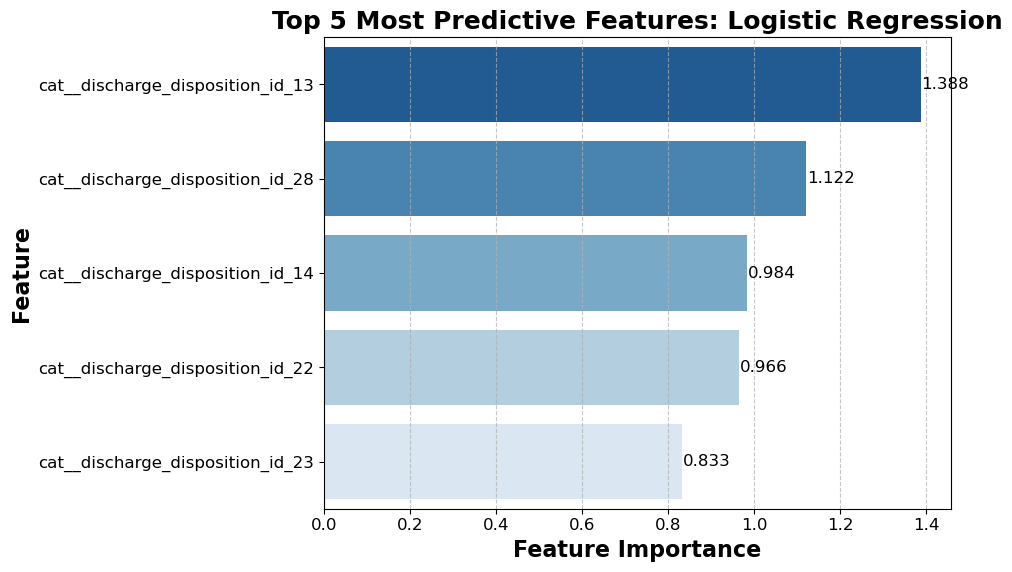

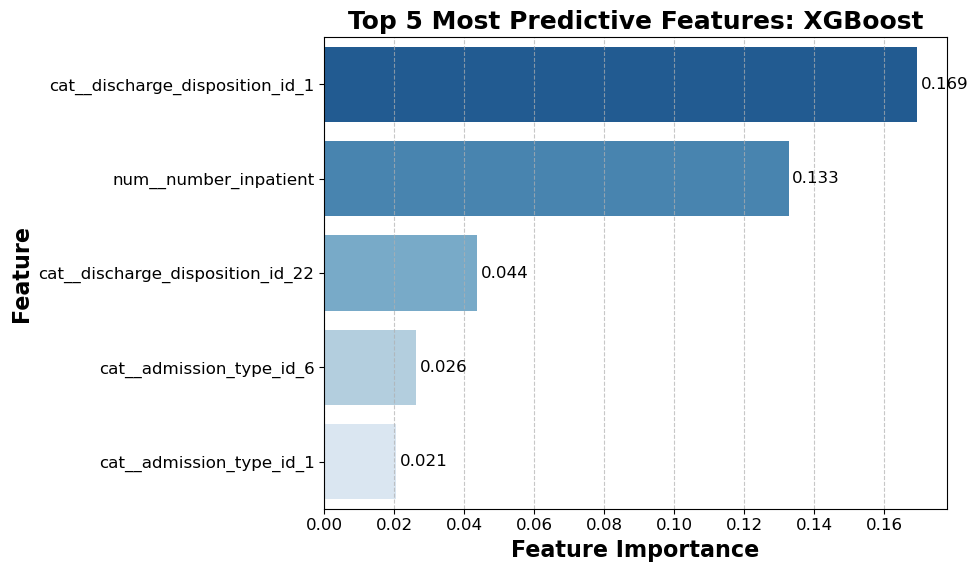

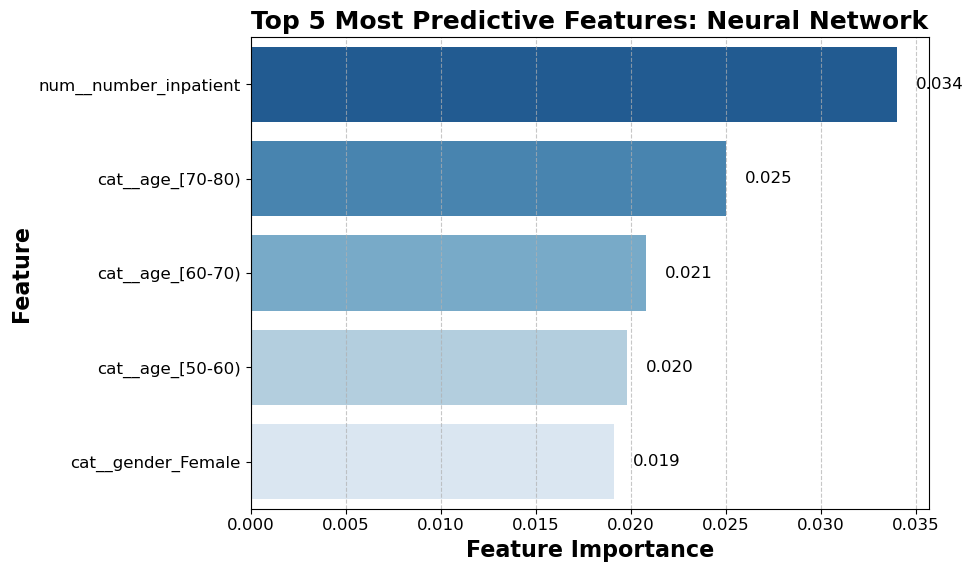

In [18]:
save_dir = "../figs/"
os.makedirs(save_dir, exist_ok=True)

# --- Helper to plot from most to least important ---
def plot_top_features_sorted(feature_df, model_name, save_name):
    # Sort by importance descending (most important first)
    top_features = feature_df.sort_values(by='importance', ascending=False).head(5)

    # Create darker-to-lighter color gradient
    colors = sns.color_palette("Blues", n_colors=len(top_features))[::-1]

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        x='importance',
        y='feature',
        data=top_features,
        palette= colors,
    )

    # Annotate importance values
    for i, v in enumerate(top_features['importance']):
        ax.text(v + 0.001, i, f"{v:.3f}", color='black', va='center', fontsize=12)

    plt.xlabel('Feature Importance', fontsize=16, fontweight='bold')
    plt.ylabel('Feature', fontsize=16, fontweight='bold')
    plt.title(f'Top 5 Most Predictive Features: {model_name}', fontsize=18, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, save_name), format='pdf', dpi=300)
    plt.show()

# --- Logistic Regression ---
plot_top_features_sorted(feature_importance_logreg, model_name="Logistic Regression", save_name="top5_logreg_features_sorted.pdf")

# --- XGBoost ---
plot_top_features_sorted(feature_importance_xgb, model_name="XGBoost", save_name="top5_xgb_features_sorted.pdf")

# --- Neural Network ---
importance_df_nn_renamed = importance_df_nn.rename(columns={'Feature': 'feature', 'Importance': 'importance'})
plot_top_features_sorted(importance_df_nn_renamed, model_name="Neural Network", save_name="top5_nn_features_sorted.pdf")


### --- Subgroup Analysis ---

In [14]:
# From your cleaned dataframe
age_groups = sorted(df['age'].unique())
gender_groups = sorted(df['gender'].unique())
race_groups = sorted(df['race'].unique())

print("Age Groups:", age_groups)
print("Gender Groups:", gender_groups)
print("Race Groups:", race_groups)


Age Groups: ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
Gender Groups: ['Female', 'Male']
Race Groups: ['AfricanAmerican', 'Asian', 'Caucasian', 'Hispanic', 'Other', 'Unknown']


In [15]:
# --- Helper functions ---
def compute_sensitivity_specificity(y_true, y_pred_binary):
    cm = confusion_matrix(y_true, y_pred_binary)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    return sensitivity, specificity

def evaluate_subgroups_xgb(X_test, y_test, subgroup_feature, model_pipeline, preprocessor, name="Model"):
    results = []
    
    for group in sorted(X_test[subgroup_feature].dropna().unique()):
        idx = X_test[subgroup_feature] == group
        X_subgroup = X_test[idx]
        y_subgroup = y_test[idx]

        if len(y_subgroup) < 20:
            print(f"Skipping subgroup '{group}' due to small size ({len(y_subgroup)} samples).")
            continue

        if len(np.unique(y_subgroup)) < 2:
            print(f"Skipping subgroup '{group}' because only one class present.")
            continue

        # Preprocess
        X_subgroup_transformed = preprocessor.transform(X_subgroup)

        # Predict
        y_pred_proba = model_pipeline.named_steps['classifier'].predict_proba(X_subgroup_transformed)[:, 1]
        y_pred_binary = (y_pred_proba >= 0.5).astype(int)

        # Metrics
        auc = roc_auc_score(y_subgroup, y_pred_proba)
        sens, spec = compute_sensitivity_specificity(y_subgroup, y_pred_binary)
        acc = (y_subgroup == y_pred_binary).mean()

        results.append({
            'Subgroup': group,
            'Samples': len(y_subgroup),
            'Accuracy': acc,
            'AUC': auc,
            'Sensitivity': sens,
            'Specificity': spec
        })
    
    results_df = pd.DataFrame(results)
    print(f"\n{name} Subgroup Evaluation on {subgroup_feature}:\n")
    print(results_df)
    
    return results_df

# --- MAIN WORKFLOW ---
# XGBoost model subgroup evaluation
subgroup_race = evaluate_subgroups_xgb(
    X_test=X_test,
    y_test=y_test,
    subgroup_feature='race',
    model_pipeline=best_xgb,
    preprocessor=preprocessor,
    name="XGBoost"
)

subgroup_gender = evaluate_subgroups_xgb(
    X_test=X_test,
    y_test=y_test,
    subgroup_feature='gender',
    model_pipeline=best_xgb,
    preprocessor=preprocessor,
    name="XGBoost"
)

subgroup_age = evaluate_subgroups_xgb(
    X_test=X_test,
    y_test=y_test,
    subgroup_feature='age',
    model_pipeline=best_xgb,
    preprocessor=preprocessor,
    name="XGBoost"
)

# --- Combine all results into one dataframe ---
subgroup_race['Group'] = 'Race'
subgroup_gender['Group'] = 'Gender'
subgroup_age['Group'] = 'Age'

subgroup_combined = pd.concat([subgroup_race, subgroup_gender, subgroup_age], ignore_index=True)
subgroup_combined


XGBoost Subgroup Evaluation on race:

          Subgroup  Samples  Accuracy       AUC  Sensitivity  Specificity
0  AfricanAmerican     3743  0.655624  0.670023     0.572748     0.666465
1            Asian      124  0.790323  0.647343     0.555556     0.808696
2        Caucasian    15032  0.638172  0.659655     0.594579     0.643856
3         Hispanic      427  0.672131  0.706803     0.571429     0.683117
4            Other      284  0.661972  0.579968     0.458333     0.680769
5          Unknown      413  0.779661  0.752694     0.586207     0.794271

XGBoost Subgroup Evaluation on gender:

  Subgroup  Samples  Accuracy       AUC  Sensitivity  Specificity
0   Female    10757  0.630845  0.657871     0.591241     0.635972
1     Male     9266  0.664364  0.670860     0.584778     0.674404
Skipping subgroup '[0-10)' because only one class present.

XGBoost Subgroup Evaluation on age:

   Subgroup  Samples  Accuracy       AUC  Sensitivity  Specificity
0   [10-20)      130  0.876923  0.660750

,Subgroup,Samples,Accuracy,AUC,Sensitivity,Specificity,Group
0,AfricanAmerican,3743,0.655624,0.670023,0.572748,0.666465,Race
1,Asian,124,0.790323,0.647343,0.555556,0.808696,Race
2,Caucasian,15032,0.638172,0.659655,0.594579,0.643856,Race
3,Hispanic,427,0.672131,0.706803,0.571429,0.683117,Race
4,Other,284,0.661972,0.579968,0.458333,0.680769,Race
5,Unknown,413,0.779661,0.752694,0.586207,0.794271,Race
6,Female,10757,0.630845,0.657871,0.591241,0.635972,Gender
7,Male,9266,0.664364,0.670860,0.584778,0.674404,Gender
8,[10-20),130,0.876923,0.660750,0.230769,0.948718,Age
9,[20-30),346,0.719653,0.803244,0.730769,0.717687,Age


In [16]:
# Preprocess test set
X_test_transformed = preprocessor.transform(X_test)
# Global feature importance
global_perm = permutation_importance(
    best_xgb.named_steps['classifier'],
    X_test_transformed,
    y_test,
    n_repeats=30,
    random_state=42,
    scoring='roc_auc',
    n_jobs=-1
)

# Map features
feature_names = preprocessor.get_feature_names_out()

global_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": global_perm.importances_mean
}).sort_values(by="Importance", ascending=False)

print("=== Global Feature Importance ===")
print(global_importance_df.head(10))
# Function to compute subgroup feature importance
def subgroup_feature_importance(X_test, y_test, subgroup_feature, model_pipeline, preprocessor, group_name):
    feature_importances = {}
    
    for subgroup in sorted(X_test[subgroup_feature].dropna().unique()):
        idx = X_test[subgroup_feature] == subgroup
        X_subgroup = X_test[idx]
        y_subgroup = y_test[idx]

        if len(y_subgroup) < 30 or len(np.unique(y_subgroup)) < 2:
            print(f"Skipping subgroup {subgroup} (too few samples or only one class)")
            continue

        # Transform
        X_subgroup_transformed = preprocessor.transform(X_subgroup)

        # Permutation Importance
        perm = permutation_importance(
            model_pipeline.named_steps['classifier'],
            X_subgroup_transformed,
            y_subgroup,
            n_repeats=30,
            random_state=42,
            scoring='roc_auc',
            n_jobs=-1
        )
        
        df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": perm.importances_mean
        }).sort_values(by="Importance", ascending=False)
        
        feature_importances[subgroup] = df

    return feature_importances
subgroup_race_importance = subgroup_feature_importance(
    X_test, y_test, 'race', best_xgb, preprocessor, 'Race'
)

subgroup_gender_importance = subgroup_feature_importance(
    X_test, y_test, 'gender', best_xgb, preprocessor, 'Gender'
)

subgroup_age_importance = subgroup_feature_importance(
    X_test, y_test, 'age', best_xgb, preprocessor, 'Age'
)

# --- Race ---
print("\n================= Race Subgroups =================\n")
for race, df in subgroup_race_importance.items():
    print(f"\nTop 5 Features for Race Group '{race}':\n")
    print(df.head(5))

# --- Gender ---
print("\n================= Gender Subgroups =================\n")
for gender, df in subgroup_gender_importance.items():
    print(f"\nTop 5 Features for Gender Group '{gender}':\n")
    print(df.head(5))

# --- Age ---
print("\n================= Age Subgroups =================\n")
for age, df in subgroup_age_importance.items():
    print(f"\nTop 5 Features for Age Group '{age}':\n")
    print(df.head(5))

# Save to CSV
for race, df in subgroup_race_importance.items():
    df.to_csv(f"../results/feature_importance_race_{race}.csv", index=False)

for gender, df in subgroup_gender_importance.items():
    df.to_csv(f"../results/feature_importance_gender_{gender}.csv", index=False)

for age, df in subgroup_age_importance.items():
    df.to_csv(f"../results/feature_importance_age_{age}.csv", index=False)

print("All subgroup feature importances saved to ../results/")


=== Global Feature Importance ===
                              Feature  Importance
153             num__number_inpatient    0.079263
26    cat__discharge_disposition_id_1    0.021241
43   cat__discharge_disposition_id_22    0.009593
152             num__number_emergency    0.002647
30    cat__discharge_disposition_id_5    0.002644
154             num__number_diagnoses    0.002359
76                cat__diabetesMed_No    0.002162
150              num__num_medications    0.001954
27    cat__discharge_disposition_id_2    0.001863
13                   cat__age_[50-60)    0.001835
Skipping subgroup [0-10) (too few samples or only one class)

================= Race Subgroups =================


Top 5 Features for Race Group 'AfricanAmerican':

                              Feature  Importance
153             num__number_inpatient    0.093470
26    cat__discharge_disposition_id_1    0.016842
43   cat__discharge_disposition_id_22    0.007868
30    cat__discharge_disposition_id_5    0.005836
1

Saved: ../figs/top5_features_race_AfricanAmerican.pdf


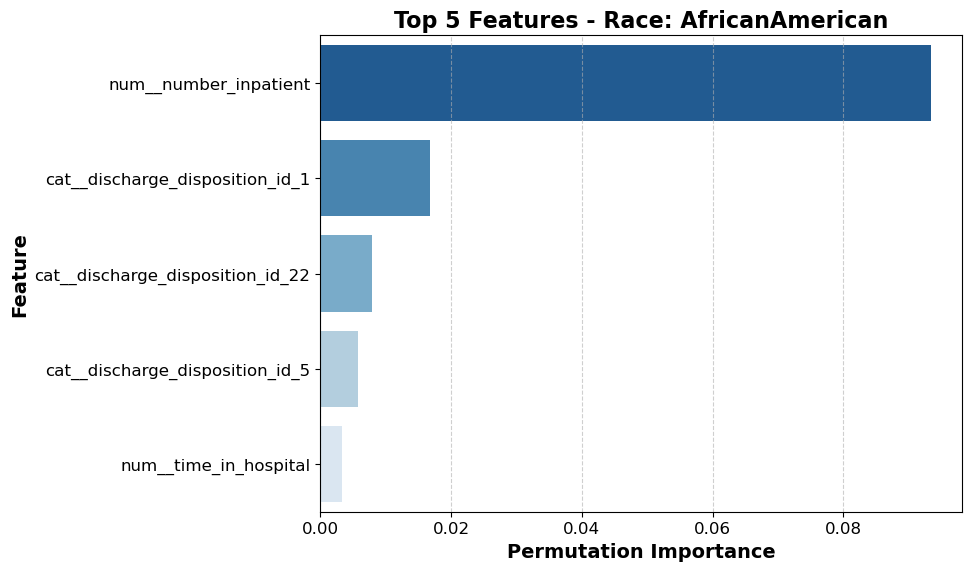

Saved: ../figs/top5_features_race_Asian.pdf


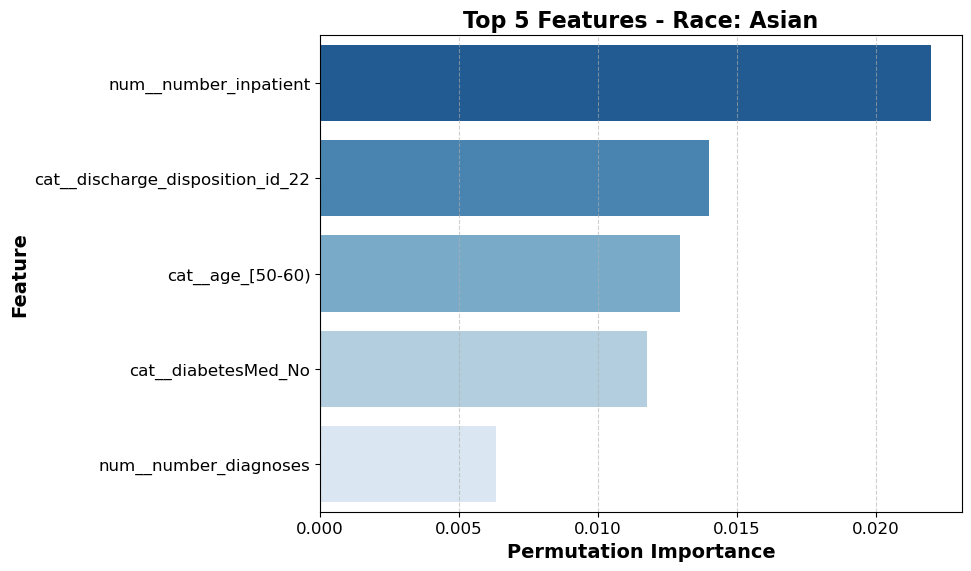

Saved: ../figs/top5_features_race_Caucasian.pdf


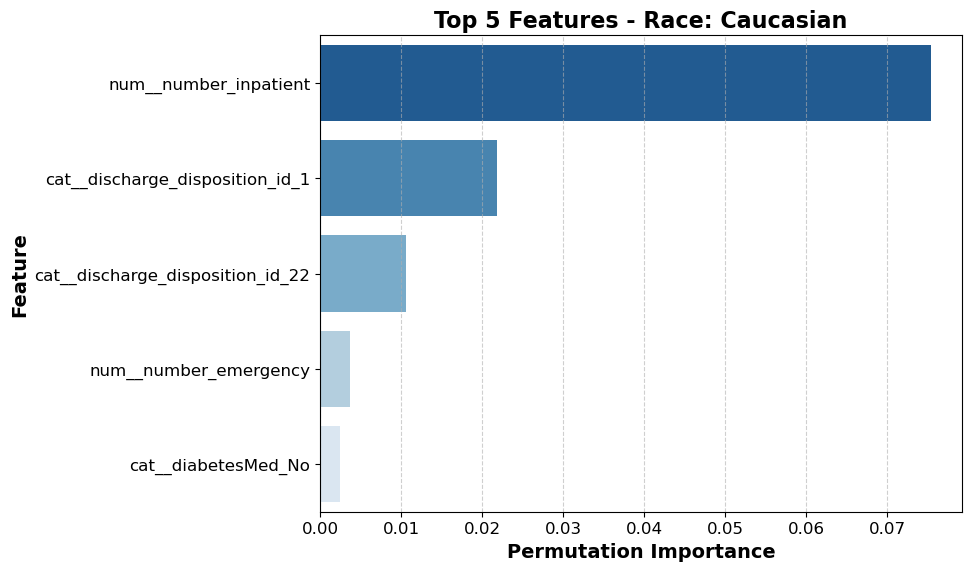

Saved: ../figs/top5_features_race_Hispanic.pdf


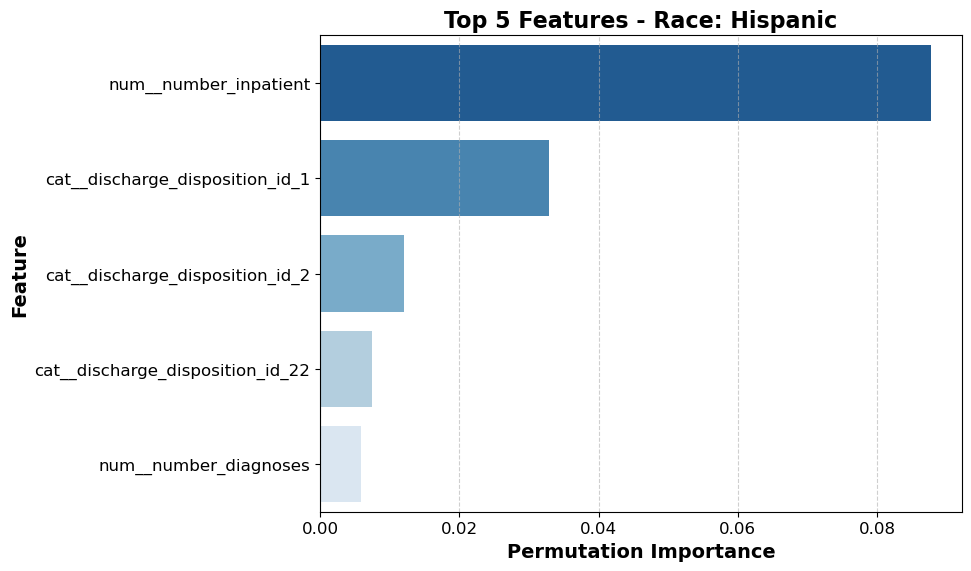

Saved: ../figs/top5_features_race_Other.pdf


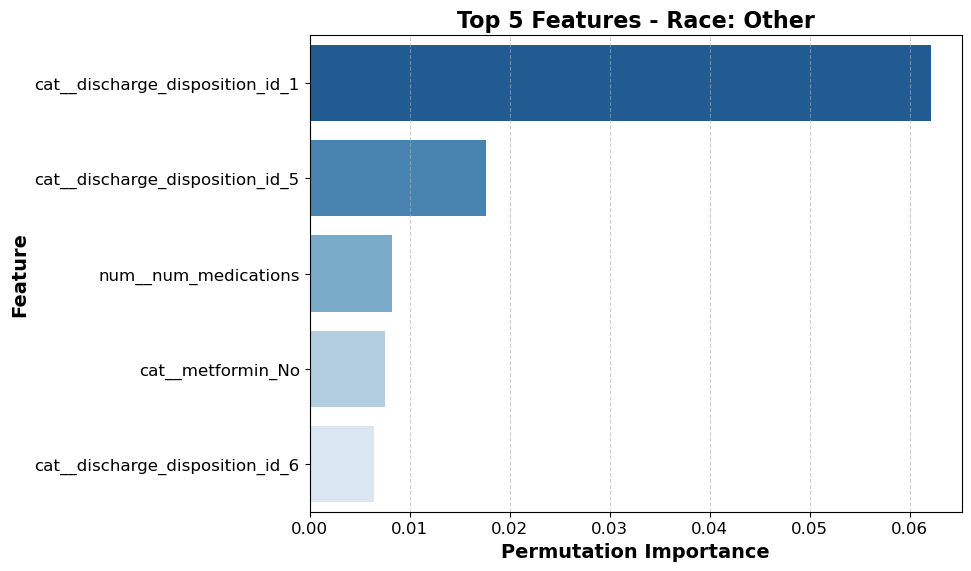

Saved: ../figs/top5_features_race_Unknown.pdf


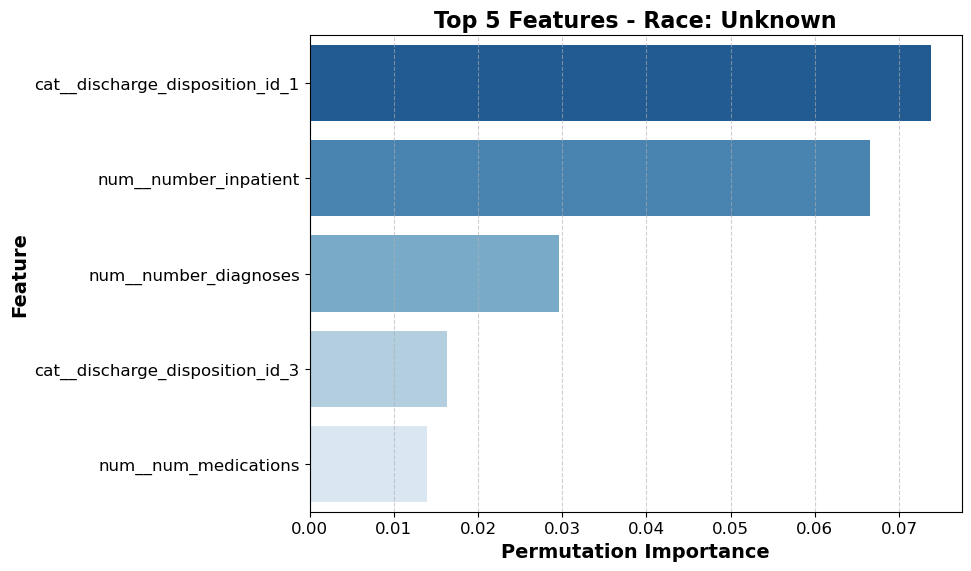

Saved: ../figs/top5_features_gender_Female.pdf


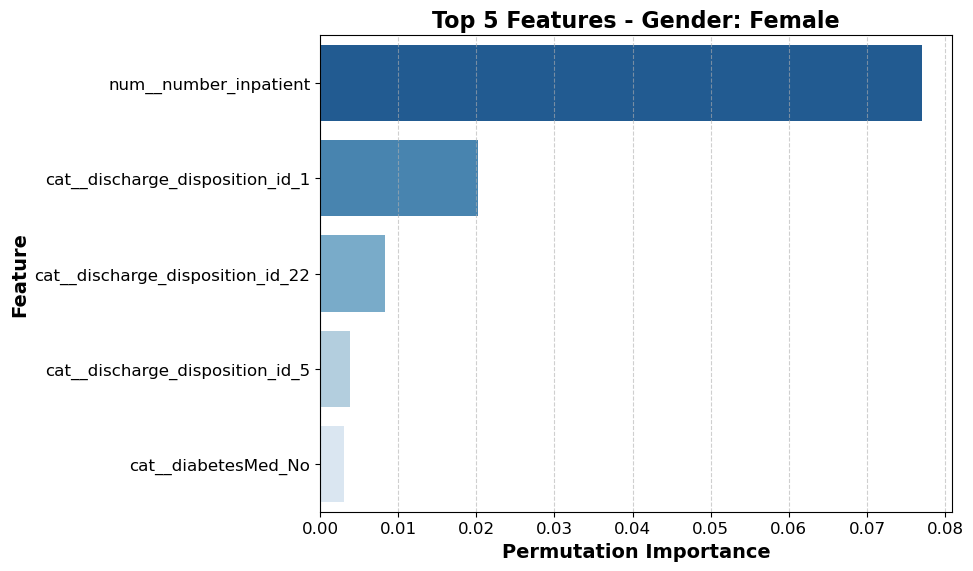

Saved: ../figs/top5_features_gender_Male.pdf


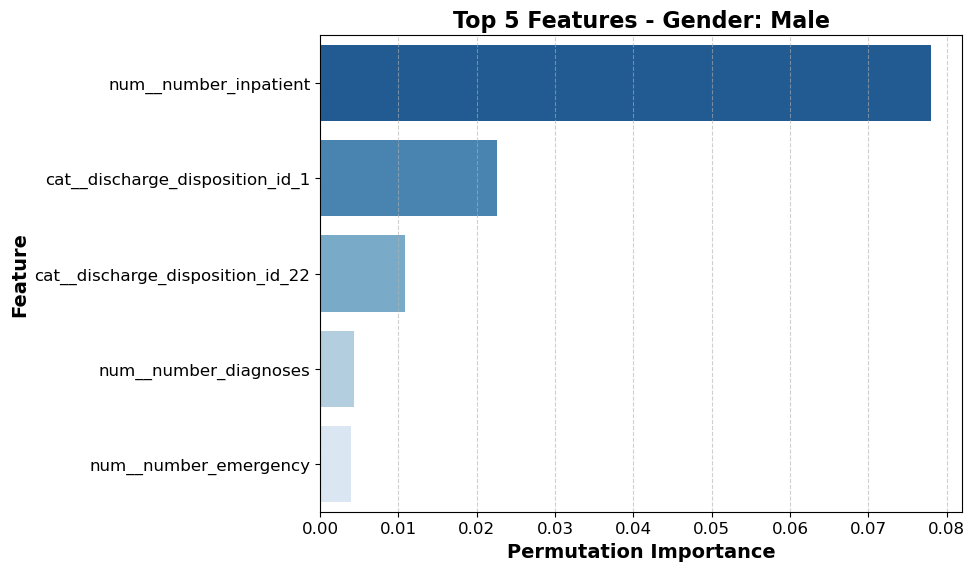

Saved: ../figs/top5_features_age_[10-20).pdf


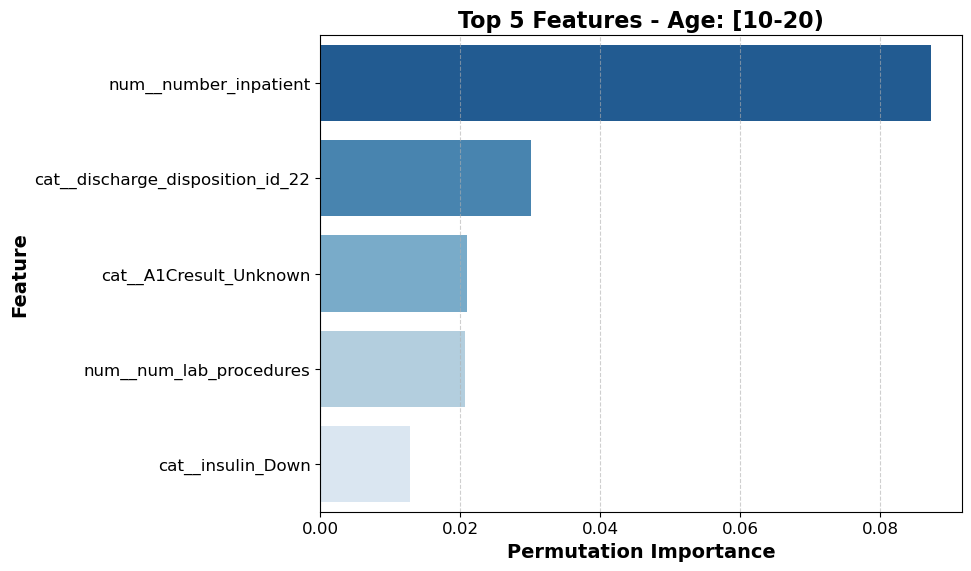

Saved: ../figs/top5_features_age_[20-30).pdf


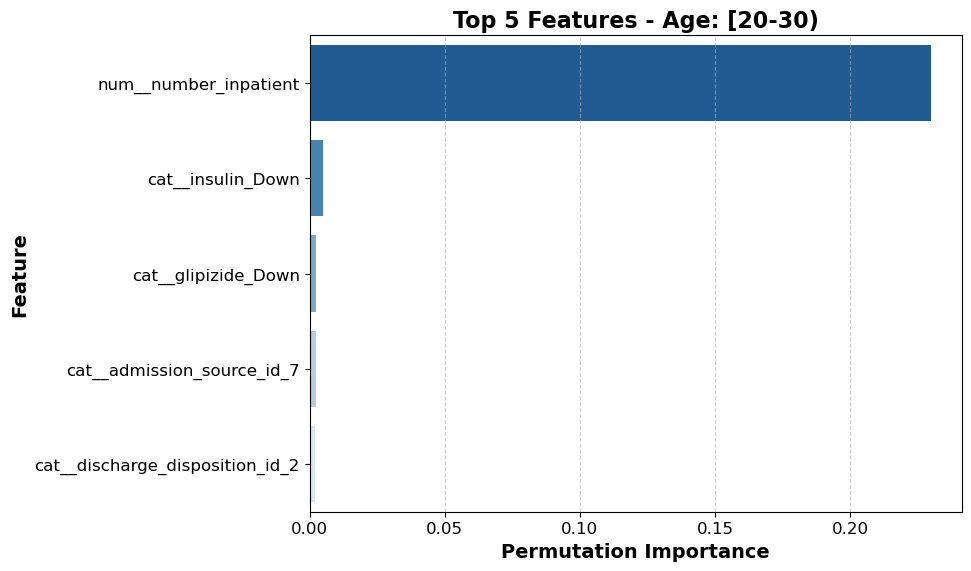

Saved: ../figs/top5_features_age_[30-40).pdf


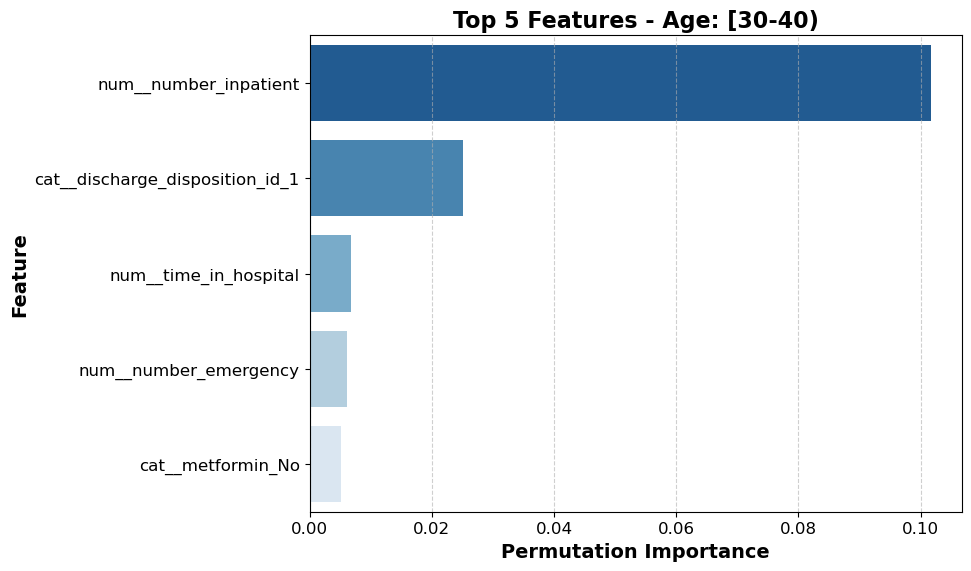

Saved: ../figs/top5_features_age_[40-50).pdf


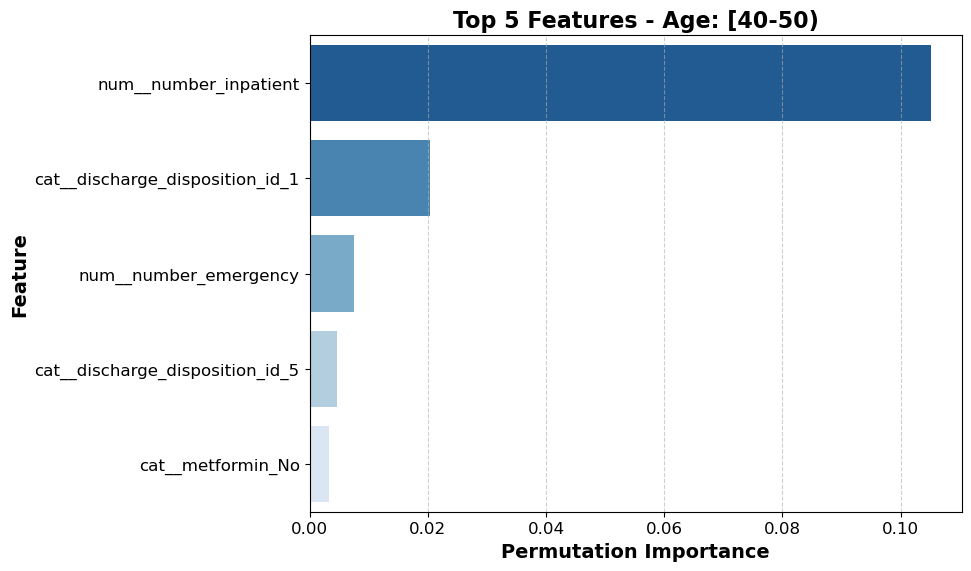

Saved: ../figs/top5_features_age_[50-60).pdf


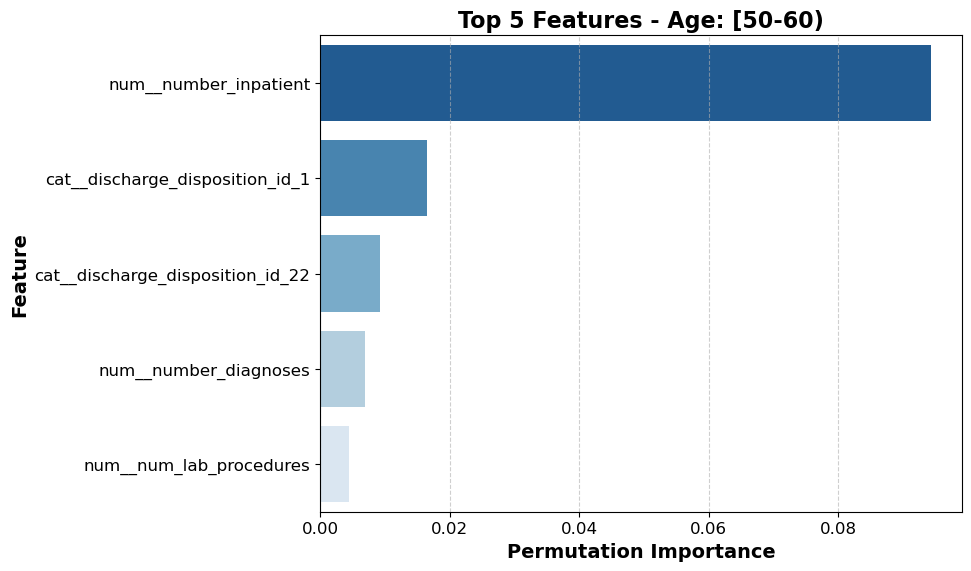

Saved: ../figs/top5_features_age_[60-70).pdf


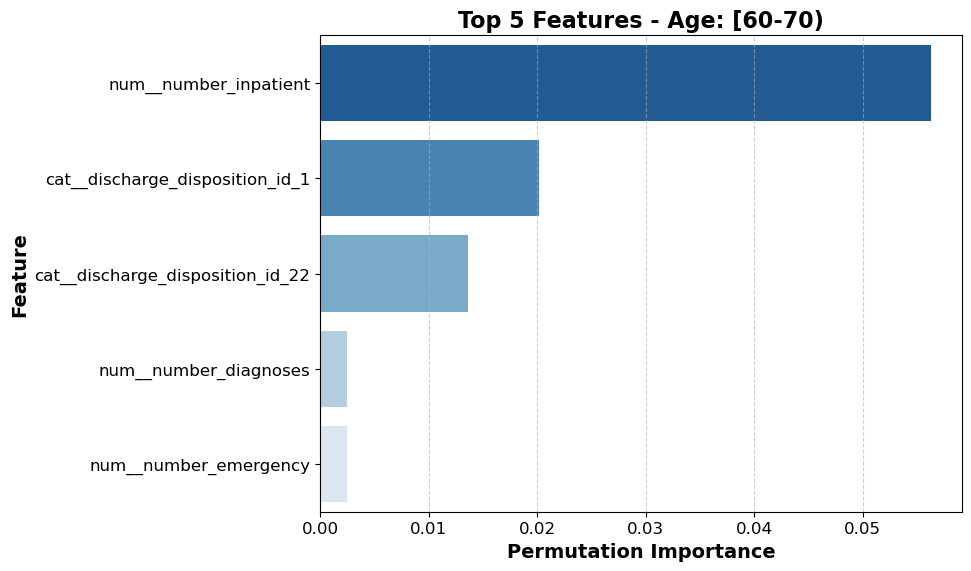

Saved: ../figs/top5_features_age_[70-80).pdf


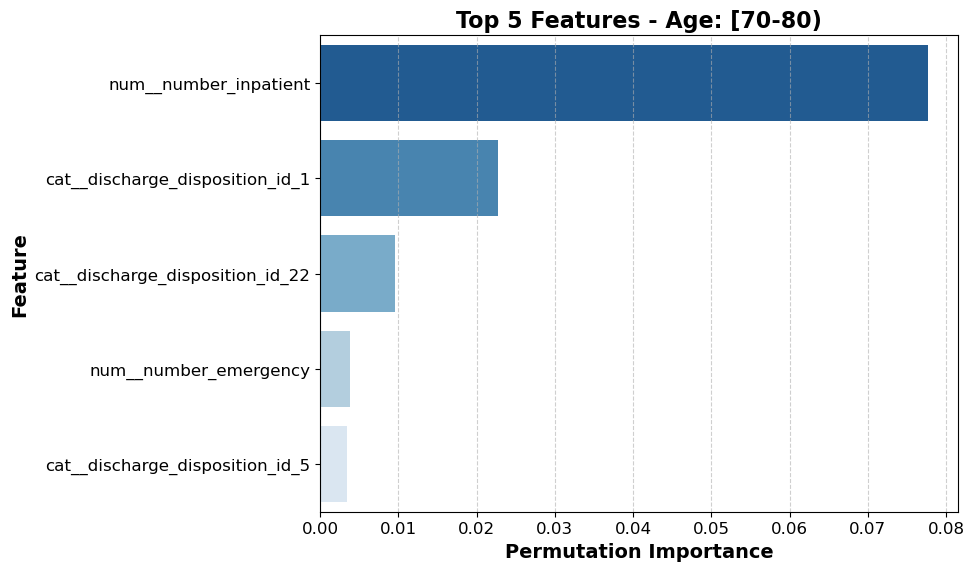

Saved: ../figs/top5_features_age_[80-90).pdf


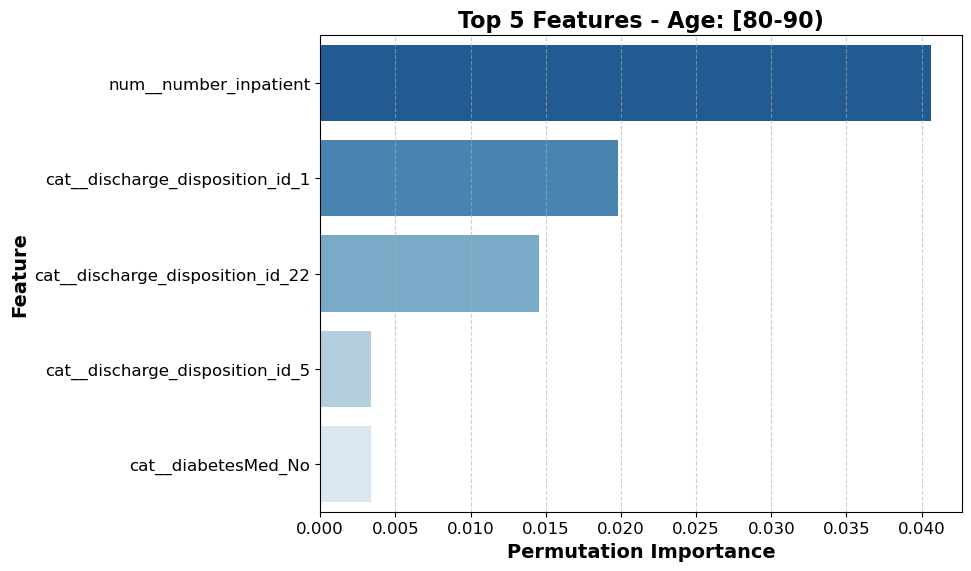

Saved: ../figs/top5_features_age_[90-100).pdf


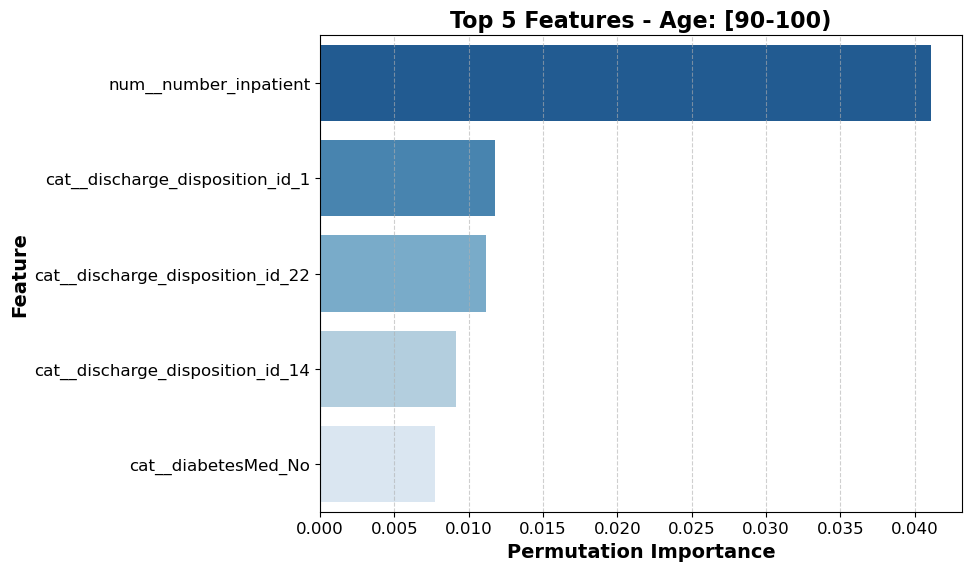

In [17]:
def plot_top5_features_per_subgroup(subgroup_importance_dict, subgroup_name, save_dir="../figs/"):
    os.makedirs(save_dir, exist_ok=True)
    
    for subgroup, df in subgroup_importance_dict.items():
        # Only take top 5
        top5 = df.head(5)

        # Plot
        plt.figure(figsize=(10, 6))
        sns.barplot(
            data=top5,
            x='Importance',
            y='Feature',
            palette='Blues_r'
        )

        plt.xlabel('Permutation Importance', fontsize=14, fontweight='bold')
        plt.ylabel('Feature', fontsize=14, fontweight='bold')
        plt.title(f'Top 5 Features - {subgroup_name}: {subgroup}', fontsize=16, fontweight='bold')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        plt.tight_layout()

        save_path = os.path.join(save_dir, f"top5_features_{subgroup_name.lower()}_{subgroup}.pdf")
        plt.savefig(save_path, format='pdf', dpi=300)
        print(f"Saved: {save_path}")

        plt.show()

# --- Plot for each subgroup type ---
plot_top5_features_per_subgroup(subgroup_race_importance, "Race")
plot_top5_features_per_subgroup(subgroup_gender_importance, "Gender")
plot_top5_features_per_subgroup(subgroup_age_importance, "Age")
